In [230]:
import numpy as np
import pandas as pd
from scipy.stats import norm

In [231]:
def get_sdt(
    tp: int, tn: int, fp: int, fn: int, correction: bool = True
) -> tuple[np.ndarray, np.ndarray]:
    tp = np.array(tp, dtype=float)
    tn = np.array(tn, dtype=float)
    fp = np.array(fp, dtype=float)
    fn = np.array(fn, dtype=float)

    if correction:
        tp += 0.5
        tn += 0.5
        fp += 0.5
        fn += 0.5

    hit_rate = tp / (tp + fn)
    false_alarm_rate = fp / (fp + tn)

    z_h = norm.ppf(hit_rate)
    z_fa = norm.ppf(false_alarm_rate)

    d_prime = z_h - z_fa
    criterion = -0.5 * (z_h + z_fa)

    return d_prime, criterion

In [232]:
vlm_data = pd.read_csv("vlm.csv")
cv_data = pd.read_csv("cv.csv")
human_data = pd.read_csv("human.csv")

data = pd.concat([cv_data, vlm_data, human_data], ignore_index=True)

In [ ]:
from typing import Literal

import matplotlib.pyplot as plt
import seaborn as sns


def get_plot_data(
    df: pd.DataFrame, type: Literal["contrast", "noise", "jigsaw", "eidolen"]
) -> pd.DataFrame:
    plot_data = []

    baseline_df = df[df["Dataset"] == "dataset"].copy()
    for _, row in baseline_df.iterrows():
        d_prime, criterion = get_sdt(row["TP"], row["TN"], row["FP"], row["FN"])
        plot_data.append(
            {
                "Model": row["Model"],
                "Level": 0,
                "d_prime": d_prime,
                "criterion": criterion,
                "Type": type,
            }
        )

    mask = df["Dataset"].str.contains(f"{type}_level")
    filtered_df = df[mask].copy()

    filtered_df["Level"] = (
        filtered_df["Dataset"].str.extract(r"_level_(\d+)").astype(int)
    )

    for _, row in filtered_df.iterrows():
        d_prime, criterion = get_sdt(row["TP"], row["TN"], row["FP"], row["FN"])
        plot_data.append(
            {
                "Model": row["Model"],
                "Level": row["Level"],
                "d_prime": d_prime,
                "criterion": criterion,
                "Type": type,
            }
        )

    return pd.DataFrame(plot_data)


def plot_sdt_comparison(
    df: pd.DataFrame,
    type: Literal["contrast", "noise", "jigsaw", "eidolen"],
    metric: Literal["d_prime", "criterion"] = "d_prime",
):
    plot_df = get_plot_data(df, type)

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    models = plot_df["Model"].unique()
    markers = ["o", "s", "^", "D", "v", "p", "h", "*"]

    for i, model in enumerate(models):
        model_data = plot_df[plot_df["Model"] == model].sort_values("Level")
        plt.plot(
            model_data["Level"],
            model_data[metric],
            marker=markers[i % len(markers)],
            label=model,
            linewidth=2,
            markersize=8,
        )

    metric_label = "Sensitivity (d')" if metric == "d_prime" else "Criterion (C)"
    type_label = type.capitalize()

    plt.xlabel(f"{type_label} Level", fontsize=12)
    plt.ylabel(metric_label, fontsize=12)
    plt.title(f"{metric_label} vs {type_label} Level for Different Models", fontsize=14)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.xticks(sorted(plot_df["Level"].unique()))

    return plt.gcf()

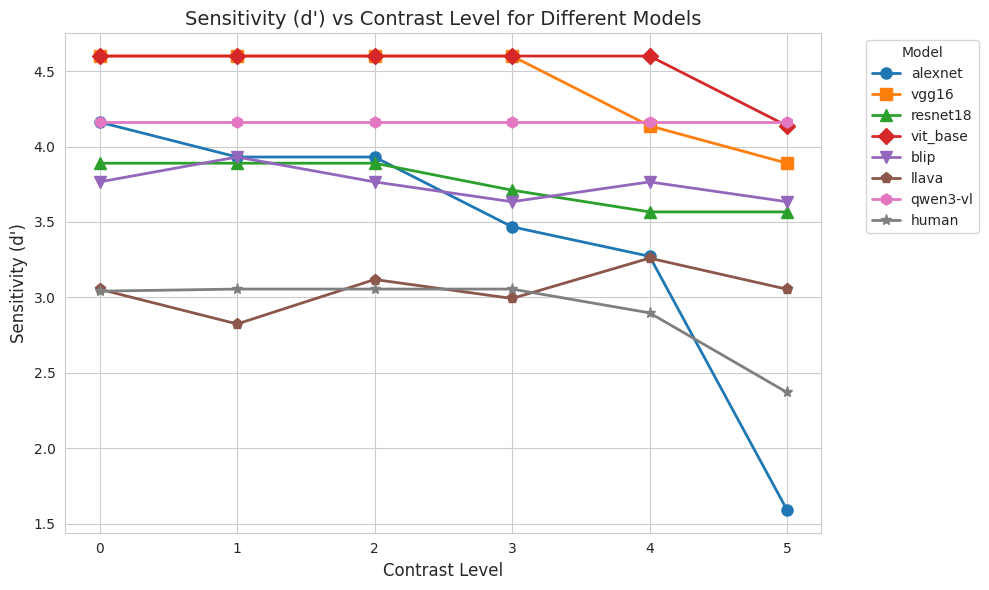

In [ ]:
plot_sdt_comparison(data, "contrast", "d_prime")
plt.show()

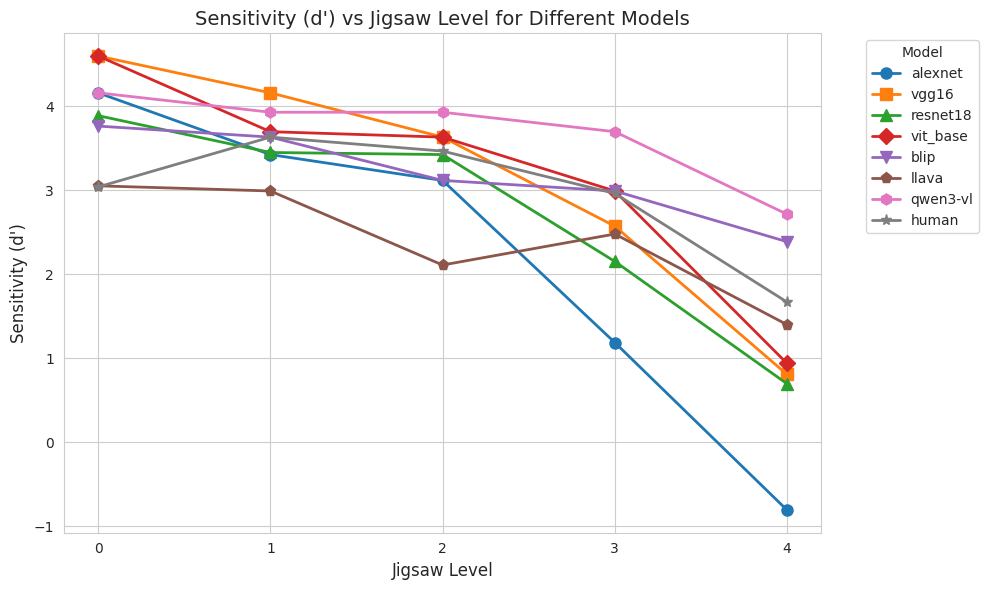

In [ ]:
plot_sdt_comparison(data, "jigsaw", "d_prime")
plt.show()

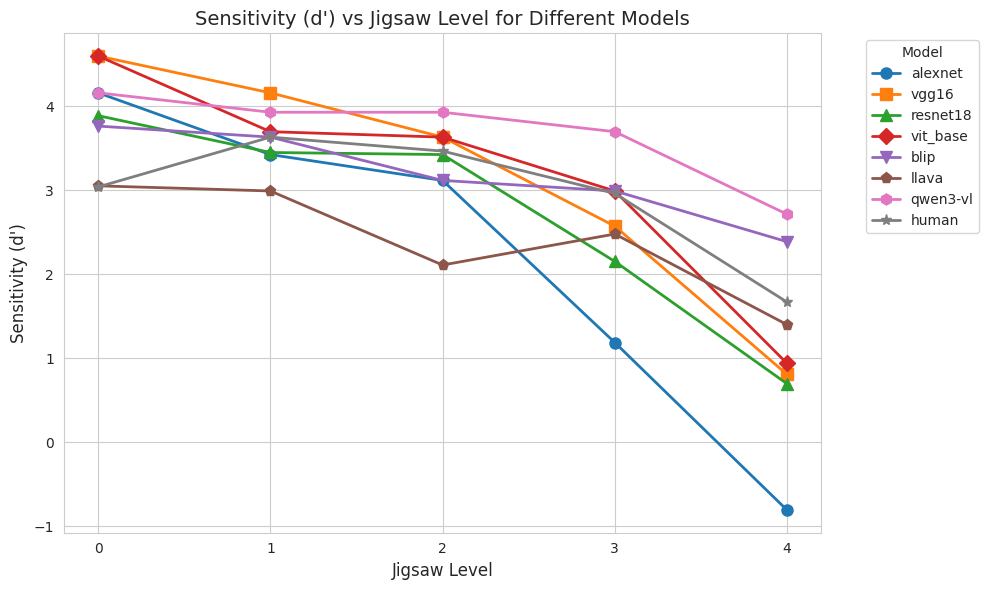

In [246]:
plot_sdt_comparison(data, "jigsaw", "d_prime")
plt.savefig("d-jigsaw")


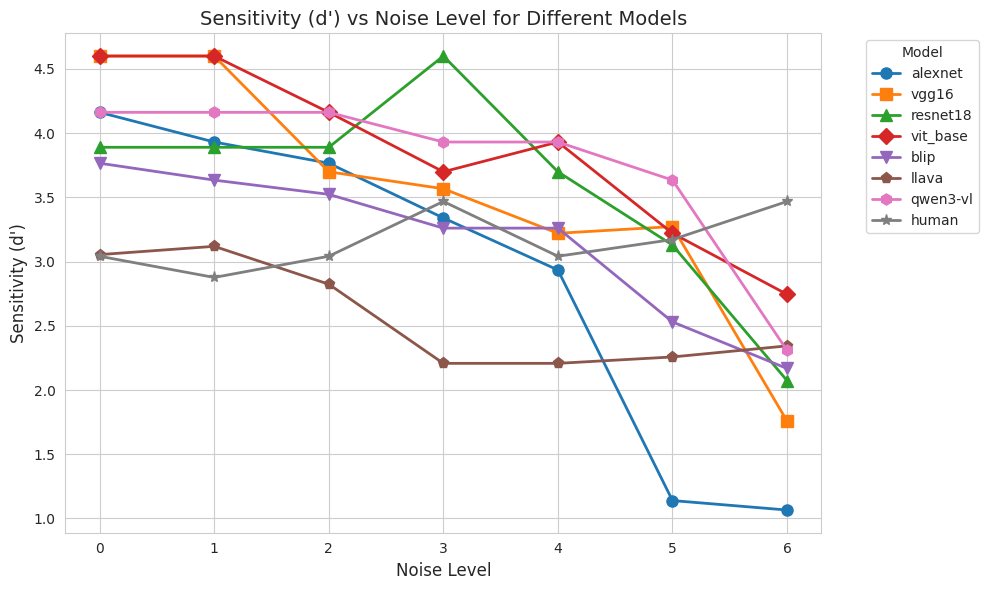

In [ ]:
plot_sdt_comparison(data, "noise", "d_prime")
plt.show()

AlexNet 有效神经元数量: 1373
ViT 有效神经元数量: 768


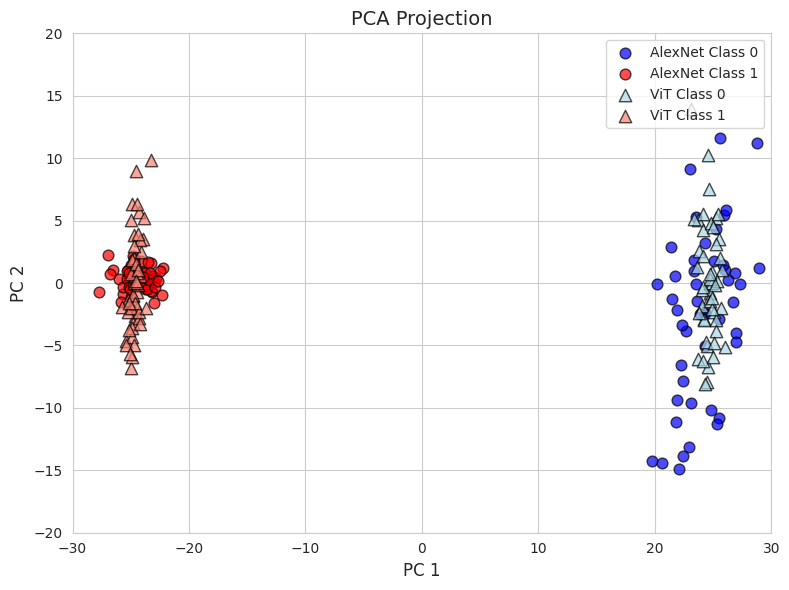

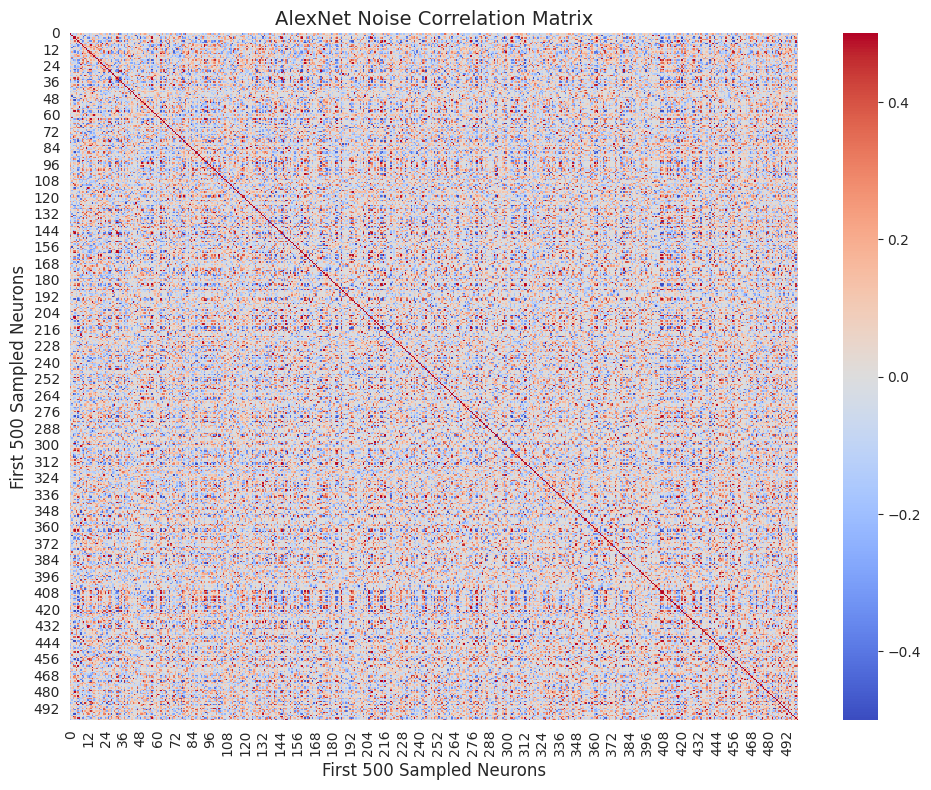

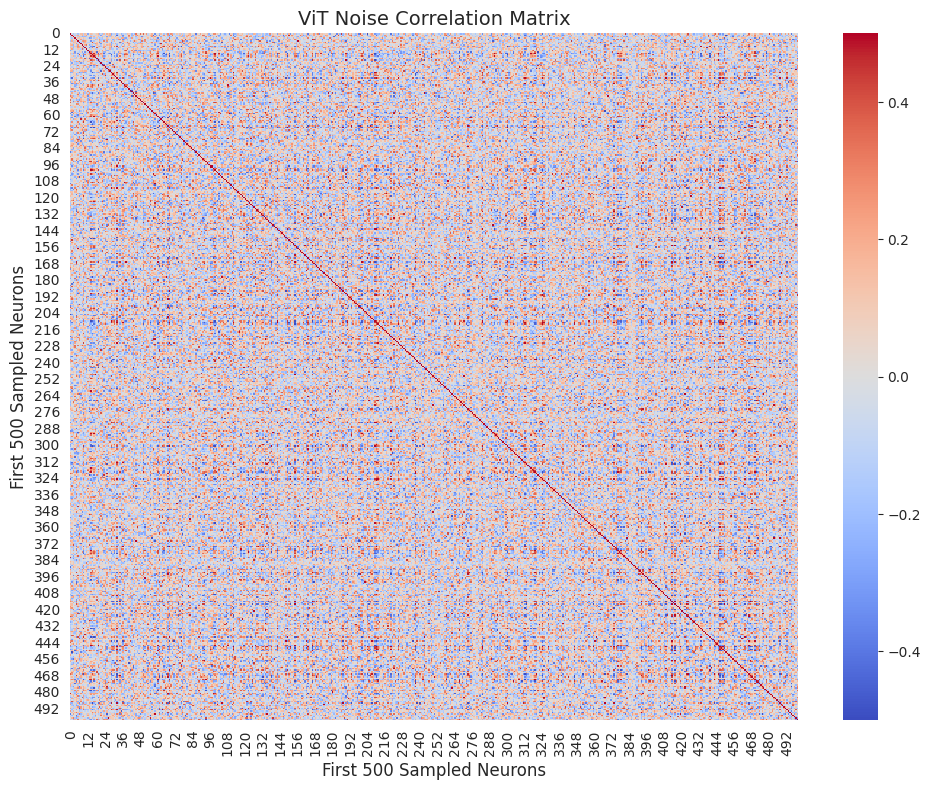

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_alexnet = np.load("alexnet_features.npy")
X_vit = np.load("vit_base_features.npy")

y = np.hstack([np.zeros(50), np.ones(50)])

std_dev_alexnet = np.std(X_alexnet, axis=0)
X_alexnet_clean = X_alexnet[:, std_dev_alexnet > 1e-5]

std_dev_vit = np.std(X_vit, axis=0)
X_vit_clean = X_vit[:, std_dev_vit > 1e-5]

if X_alexnet_clean.shape[1] > 500:
    top_var_idx_alexnet = np.argsort(np.var(X_alexnet_clean, axis=0))[-500:]
    X_alexnet_viz = X_alexnet_clean[:, top_var_idx_alexnet]
else:
    X_alexnet_viz = X_alexnet_clean

if X_vit_clean.shape[1] > 500:
    top_var_idx_vit = np.argsort(np.var(X_vit_clean, axis=0))[-500:]
    X_vit_viz = X_vit_clean[:, top_var_idx_vit]
else:
    X_vit_viz = X_vit_clean


plt.figure(figsize=(8, 6))

pca_alexnet = PCA(n_components=2)
X_alexnet_standard = StandardScaler().fit_transform(X_alexnet_clean)
X_alexnet_pca = pca_alexnet.fit_transform(X_alexnet_standard)

pca_vit = PCA(n_components=2)
X_vit_standard = StandardScaler().fit_transform(X_vit_clean)
X_vit_pca = pca_vit.fit_transform(X_vit_standard)

scatter_alexnet_c0 = plt.scatter(
    X_alexnet_pca[:50, 0],
    X_alexnet_pca[:50, 1],
    c="blue",
    marker="o",
    alpha=0.7,
    edgecolors="k",
    s=60,
    label="AlexNet Class 0",
)
scatter_alexnet_c1 = plt.scatter(
    X_alexnet_pca[50:, 0],
    X_alexnet_pca[50:, 1],
    c="red",
    marker="o",
    alpha=0.7,
    edgecolors="k",
    s=60,
    label="AlexNet Class 1",
)

scatter_vit_c0 = plt.scatter(
    X_vit_pca[:50, 0],
    X_vit_pca[:50, 1],
    c="lightblue",
    marker="^",
    alpha=0.7,
    edgecolors="k",
    s=80,
    label="ViT Class 0",
)
scatter_vit_c1 = plt.scatter(
    X_vit_pca[50:, 0],
    X_vit_pca[50:, 1],
    c="salmon",
    marker="^",
    alpha=0.7,
    edgecolors="k",
    s=80,
    label="ViT Class 1",
)

plt.title("PCA Projection", fontsize=14)
plt.xlabel("PC 1", fontsize=12)
plt.ylabel("PC 2", fontsize=12)
plt.legend(loc="upper right")

plt.xlim(-30, 30)
plt.ylim(-20, 20)

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 8))

X_alexnet_residual = np.zeros_like(X_alexnet_viz)
X_alexnet_residual[:50] = X_alexnet_viz[:50] - np.mean(X_alexnet_viz[:50], axis=0)
X_alexnet_residual[50:] = X_alexnet_viz[50:] - np.mean(X_alexnet_viz[50:], axis=0)

noise_corr_alexnet = np.corrcoef(X_alexnet_residual, rowvar=False)

subset_n = X_alexnet_viz.shape[1]
sns.heatmap(
    noise_corr_alexnet[:subset_n, :subset_n],
    cmap="coolwarm",
    center=0,
    vmin=-0.5,
    vmax=0.5,
)
plt.title(
    "AlexNet Noise Correlation Matrix",
    fontsize=14,
)
plt.xlabel(f"First {subset_n} Sampled Neurons", fontsize=12)
plt.ylabel(f"First {subset_n} Sampled Neurons", fontsize=12)

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 8))

X_vit_residual = np.zeros_like(X_vit_viz)
X_vit_residual[:50] = X_vit_viz[:50] - np.mean(X_vit_viz[:50], axis=0)
X_vit_residual[50:] = X_vit_viz[50:] - np.mean(X_vit_viz[50:], axis=0)

noise_corr_vit = np.corrcoef(X_vit_residual, rowvar=False)

sns.heatmap(
    noise_corr_vit[:subset_n, :subset_n],
    cmap="coolwarm",
    center=0,
    vmin=-0.5,
    vmax=0.5,
)
plt.title(
    "ViT Noise Correlation Matrix",
    fontsize=14,
)
plt.xlabel(f"First {subset_n} Sampled Neurons", fontsize=12)
plt.ylabel(f"First {subset_n} Sampled Neurons", fontsize=12)

plt.tight_layout()
plt.show()